In [71]:
import os
import sys
import argparse
import csv
import pandas as pd
import datetime as dt
import numpy as np
from pprint import pprint
from tqdm import tqdm
from pytictoc import TicToc
import traceback
from statistics import median
from statistics import mean
from statistics import mode
from statistics import stdev
from scipy import stats
from scipy import signal
import portion as P
import math
import random
import itertools

def makedir(dirpath, mode=0):  # mode=1: show message, mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

# Define Functions

In [72]:
def merge_data(dfs, devices=devices, schemes=schemes):
    st, et = [], []
    for i, (dev, schm) in enumerate(zip(devices, schemes)):
        st.append(dfs[i]['sequence_num'].array[0])
        et.append(dfs[i]['sequence_num'].array[-1])
    st, et = max(st), min(et)
    for i, (dev, schm) in enumerate(zip(devices, schemes)):
        dfs[i] = dfs[i][(dfs[i]['sequence_num'] >= st) & (dfs[i]['sequence_num'] <= et)]
        dfs[i].reset_index(drop=True, inplace=True)
        # dfs[i] = dfs[i].drop(['transmit_time','arrival_time'], axis=1)
        for col in dfs[i].columns[2:]:
            dfs[i] = dfs[i].rename(columns={col:f'{col}_{schm}'})
    df = dfs[0][['sequence_num','Timestamp']]
    for i, (dev, schm) in enumerate(zip(devices, schemes)):
        dfs[i] = dfs[i].drop(['sequence_num','Timestamp'], axis=1)
    df = pd.concat([df, *dfs], axis=1)
    return df

def add_combo(df, schemes=schemes):
    xs = list(itertools.combinations(range(len(schemes)), 2))
    for x in xs:
        df[f'lost_{schemes[x[0]]}_{schemes[x[1]]}'] = df[f'lost_{schemes[x[0]]}'] & df[f'lost_{schemes[x[1]]}']
        df[f'excl_{schemes[x[0]]}_{schemes[x[1]]}'] = df[f'excl_{schemes[x[0]]}'] & df[f'excl_{schemes[x[1]]}']
        df[f'latency_{schemes[x[0]]}_{schemes[x[1]]}'] = df[[f'latency_{schemes[x[0]]}', f'latency_{schemes[x[1]]}']].min(axis=1)
    return df

# Testing

In [8]:
devices = ['qc01','qc02','qc03']
schemes = ['B3','B7','B8']
dfs = []
testpath = [
    '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc01/#01/data/udp_dnlk_loss_latency_ho.pkl',
    '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency_ho.pkl',
    '/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency_ho.pkl',
]
for i, (dev, schm) in enumerate(zip(devices, schemes)):
    dfs.append(pd.read_pickle(testpath[i]))
df = merge_data(dfs)
df = add_combo(df)

In [10]:
df.dtypes

sequence_num              Int32
Timestamp        datetime64[ns]
lost_B3                 boolean
excl_B3                 boolean
latency_B3              float32
                      ...      
excl_B3_B8              boolean
latency_B3_B8           float32
lost_B7_B8              boolean
excl_B7_B8              boolean
latency_B7_B8           float32
Length: 65, dtype: object

In [92]:
database = "/home/wmnlab/D/database/"
dates = [
        #  "2023-02-04",
        #  "2023-02-04#1",
         "2023-02-04#2",
         ]
devices = [
    "qc01",
    "qc02",
    "qc03",
]
schemes = [
    # "B3",
    # "B7",
    # "B8",
    "All@qc01",
    "All@qc02",
    "All@qc03",
]
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "_Bandlock_Udp_B3_B7_B8_RM500Q": (2, ["#01", "#02"]),
    "_Bandlock_Udp_all_RM500Q": (2, ["#01", "#02"]),
    # "_Bandlock_Udp_B3_B7_B8_RM500Q": (1, ["#01",]),
    # "_Bandlock_Udp_all_RM500Q": (1, ["#01",]),
}

for date in dates:
    for expr, (times, traces) in exps.items():
        for trace in traces:
            target_dir = os.path.join(database, date, expr, "combo", trace)
            makedir(target_dir)
            for tag in ["dnlk", "uplk"]:
                print("------------------------------------------")
                print(date, expr, trace, tag)  
                print("------------------------------------------")
                t = TicToc()
                t.tic()
                dfs = []
                for i, (dev, scheme) in enumerate(zip(devices, schemes)):
                    source_dir = os.path.join(database, date, expr, dev, trace, "data")
                    dfs.append(pd.read_pickle(os.path.join(source_dir, f'udp_{tag}_loss_latency_ho.pkl')))
                ### TODO 1
                df = merge_data(dfs)
                ### TODO 2
                df = add_combo(df)
                df.to_pickle(os.path.join(target_dir, f'udp_{tag}_combo_loss_latency_ho.pkl'))
                ### TODO END
                t.toc()
                

------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #01 dnlk
------------------------------------------
Elapsed time is 1.639710 seconds.
------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #01 uplk
------------------------------------------
Elapsed time is 2.020596 seconds.
------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #02 dnlk
------------------------------------------
Elapsed time is 1.749797 seconds.
------------------------------------------
2023-02-04#2 _Bandlock_Udp_all_RM500Q #02 uplk
------------------------------------------
Elapsed time is 1.479917 seconds.


# Heatmap

In [93]:
import itertools as it
import matplotlib.pylab as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

def mask(size, mode='lower', diag=True):
    if mode == 'lower':  # 保留下三角（遮蔽上三角）
        mask = np.ones((size, size))
        if diag:  # 保留對角線
            for i in range(size):
                for j in range(i+1):
                    mask[i][j] = 0
        else:  # 遮蔽對角線
            for i in range(1, 3):
                for j in range(i):
                    mask[i][j] = 0
    elif mode == 'upper':  # 保留上三角（遮蔽下三角）
        mask = np.zeros((size, size))
        if diag:  # 保留對角線
            for i in range(1, 3):
                for j in range(i):
                    mask[i][j] = 1
        else:  # 遮蔽對角線
            for i in range(3):
                for j in range(i+1):
                    mask[i][j] = 1
    else:
        print(f"Warning: mask() has no option '{mode}' for argument: 'mode'.")
        print("Please specify 'upper' or 'lower' instead.")
        mask = np.zeros((size, size))
    return mask

def masked(mat, mask):
    mat_new = mat
    for i, row in enumerate(mat):
        for j, element in enumerate(row):
            if mask[i][j]:
                mat_new[i][j] = 0
    return mat_new

def fill_out_matrix(schemes, mtags, dict):
    mat = np.zeros((len(schemes), len(schemes)))
    for i, row in enumerate(mat):
        for j, element in enumerate(row):
            mtag = mtags[i][j]
            if mtag:
                mat[i][j] = dict[mtag]
    mat = pd.DataFrame(mat, index=schemes, columns=schemes)
    return mat

In [94]:
schemes = ['B3','B7','B8']

xs = list(it.combinations(schemes, 2))
tags = [*schemes, *['_'.join([s[0], s[1]]) for s in xs]]
print(tags)

xs = list(it.product(schemes, repeat=2))
xs = ['_'.join([s[0], s[1]]) if s[0] != s[1] else s[0] for s in xs]
print(xs)
xs = np.reshape(xs, (len(schemes), len(schemes)))
mtags = masked(xs.tolist(), mask(len(schemes), mode='upper'))
display(pd.DataFrame(mtags))

['B3', 'B7', 'B8', 'B3_B7', 'B3_B8', 'B7_B8']
['B3', 'B3_B7', 'B3_B8', 'B7_B3', 'B7', 'B7_B8', 'B8_B3', 'B8_B7', 'B8']


,0,1,2
0,B3,B3_B7,B3_B8
1,0,B7,B7_B8
2,0,0,B8


In [95]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_uplk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_dnlk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_uplk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_uplk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_dnlk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_uplk_combo_loss_latency_ho.pkl")
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency_ho.pkl")

## UL Loss / Excl

{'B3': 0.0478196, 'B7': 0.0562323, 'B8': 0.1058229, 'B3_B7': 0.0, 'B3_B8': 0.0013283, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.04782,0.000000,0.001328
B7,0.00000,0.056232,0.000000
B8,0.00000,0.000000,0.105823


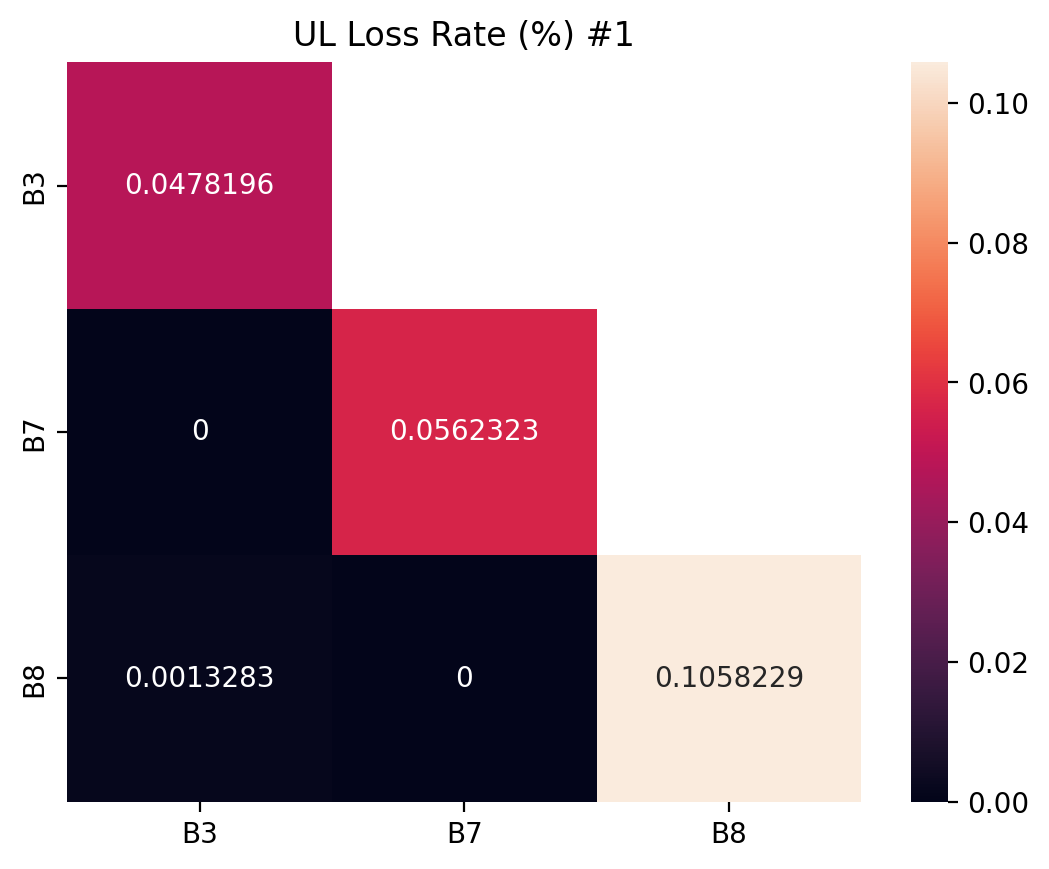

{'B3': 0.4252661, 'B7': 0.5515634, 'B8': 0.3612429, 'B3_B7': 0.013726, 'B3_B8': 0.0008856, 'B7_B8': 0.0451629}


,B3,B7,B8
B3,0.425266,0.013726,0.000886
B7,0.000000,0.551563,0.045163
B8,0.000000,0.000000,0.361243


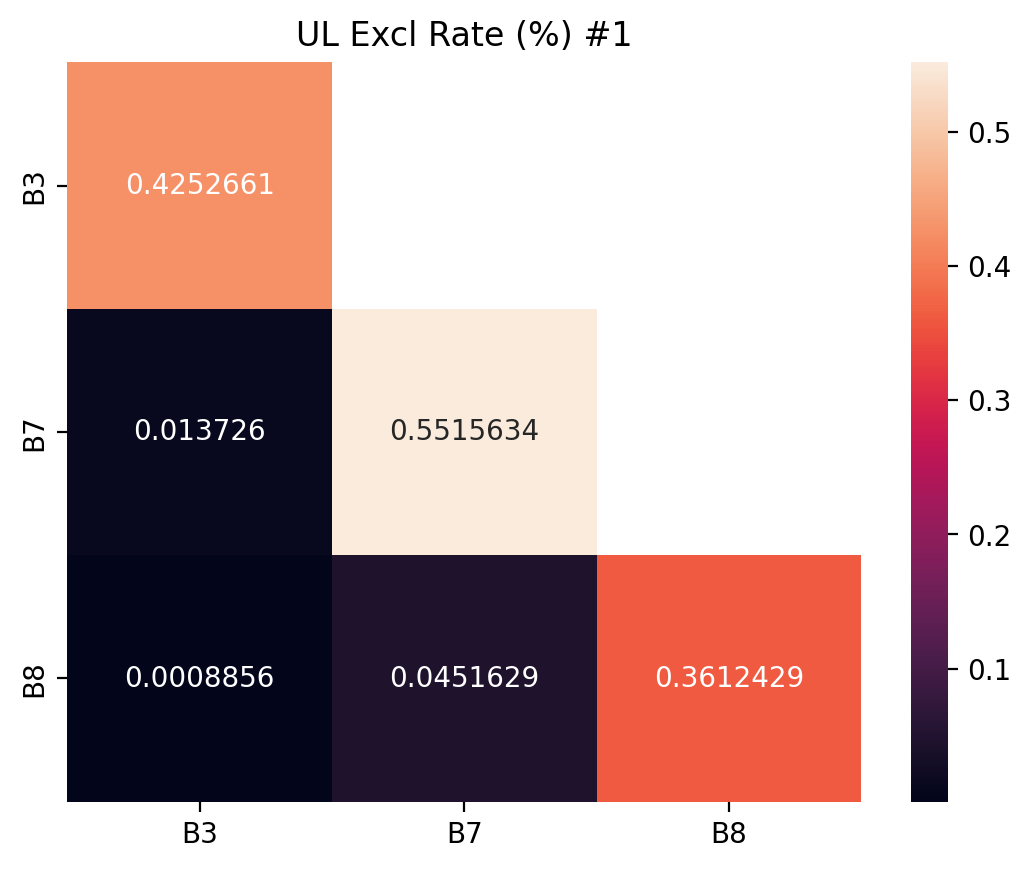

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8
118377,128918,2023-02-04 15:02:53.728177,after,MN_HO,after,SN_Setup
166395,176936,2023-02-04 15:04:29.766107,stable,stable,stable,stable
166407,176948,2023-02-04 15:04:29.790107,stable,stable,stable,stable


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


In [96]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_uplk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Loss Rate (%) #1')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Excl Rate (%) #1')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

{'B3': 0.030438, 'B7': 0.0106179, 'B8': 0.0297301, 'B3_B7': 0.0, 'B3_B8': 0.0, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.030438,0.000000,0.00000
B7,0.000000,0.010618,0.00000
B8,0.000000,0.000000,0.02973


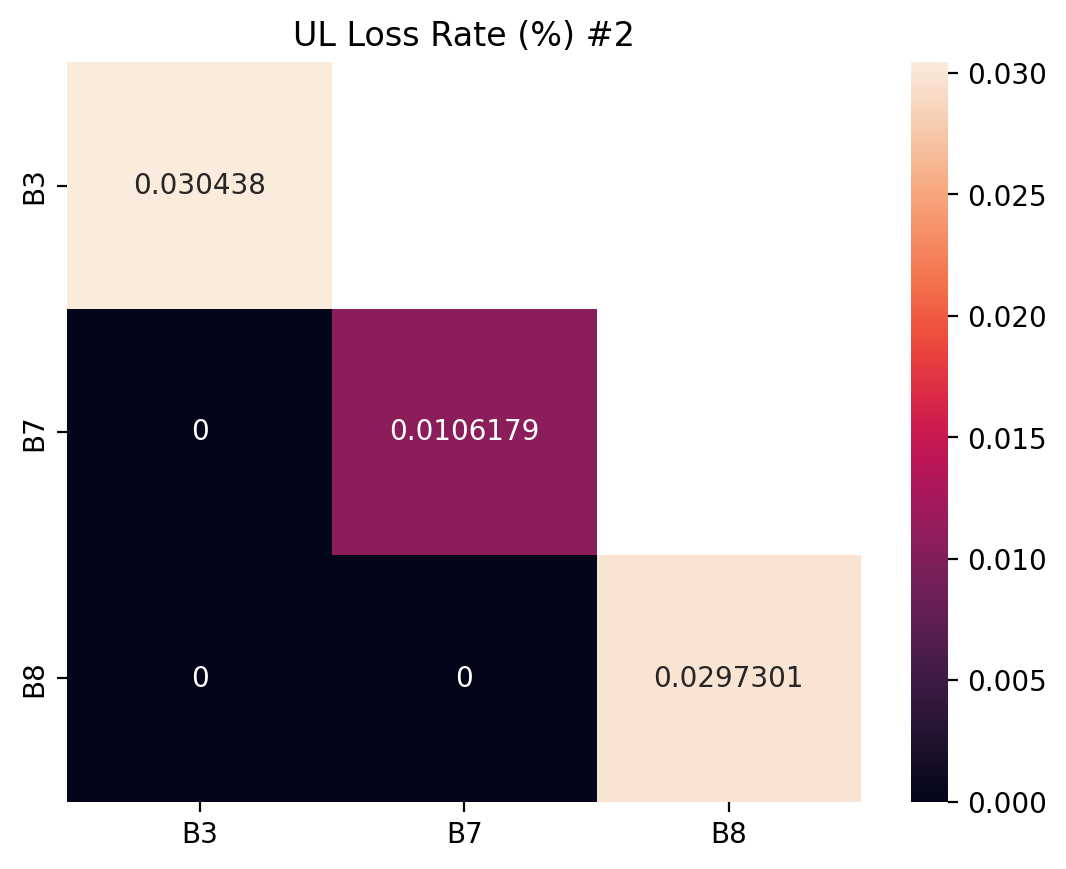

{'B3': 0.2209194, 'B7': 0.4042306, 'B8': 1.712821, 'B3_B7': 0.0162808, 'B3_B8': 0.0276065, 'B7_B8': 0.0622916}


,B3,B7,B8
B3,0.220919,0.016281,0.027606
B7,0.000000,0.404231,0.062292
B8,0.000000,0.000000,1.712821


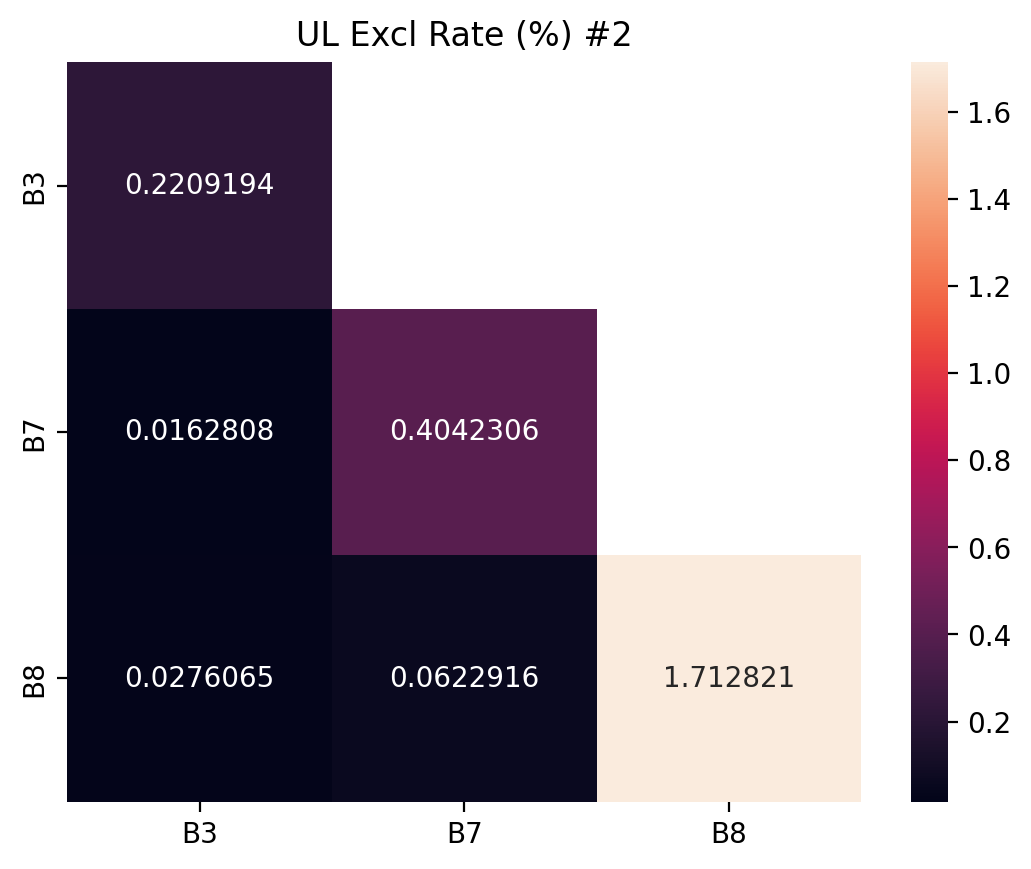

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


In [97]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_uplk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Loss Rate (%) #2')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Excl Rate (%) #2')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

{'B3': 0.0132315, 'B7': 0.0638893, 'B8': 0.052548, 'B3_B7': 0.000378, 'B3_B8': 0.000378, 'B7_B8': 0.000378}


,B3,B7,B8
B3,0.013232,0.000378,0.000378
B7,0.000000,0.063889,0.000378
B8,0.000000,0.000000,0.052548


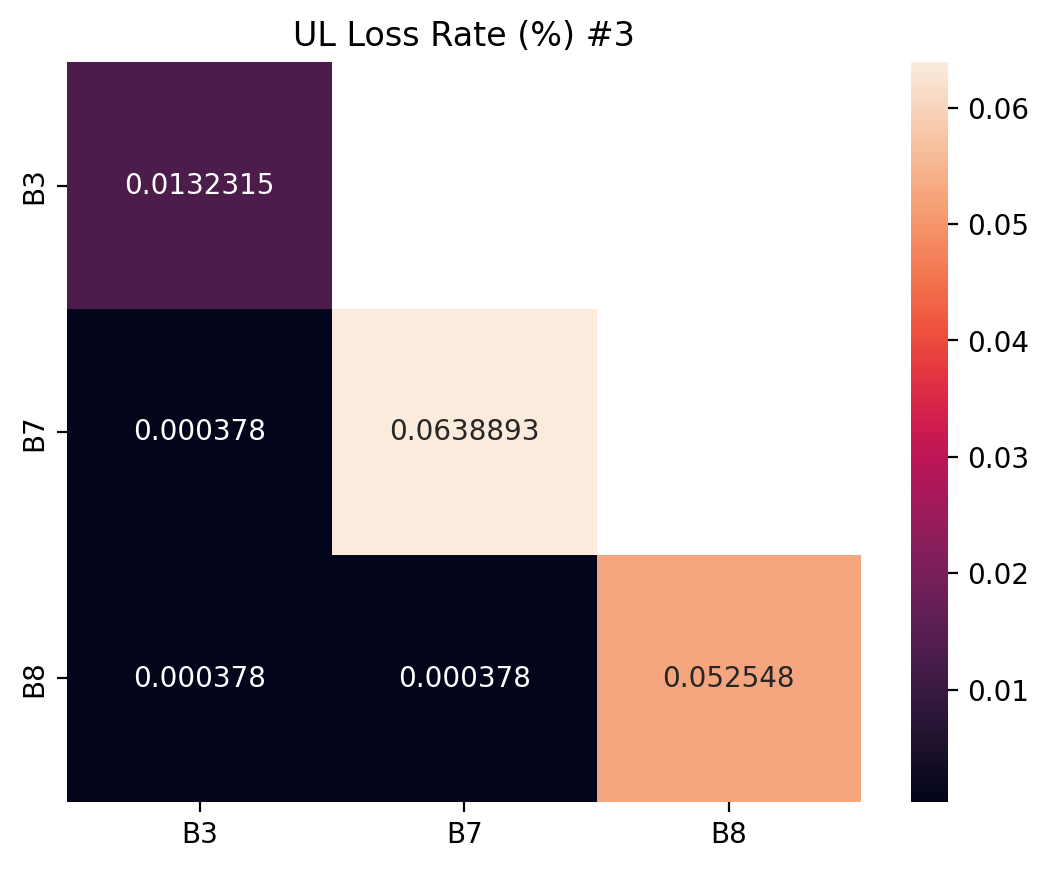

{'B3': 0.2344178, 'B7': 0.4902573, 'B8': 0.2371577, 'B3_B7': 0.0359142, 'B3_B8': 0.0022683, 'B7_B8': 0.0241949}


,B3,B7,B8
B3,0.234418,0.035914,0.002268
B7,0.000000,0.490257,0.024195
B8,0.000000,0.000000,0.237158


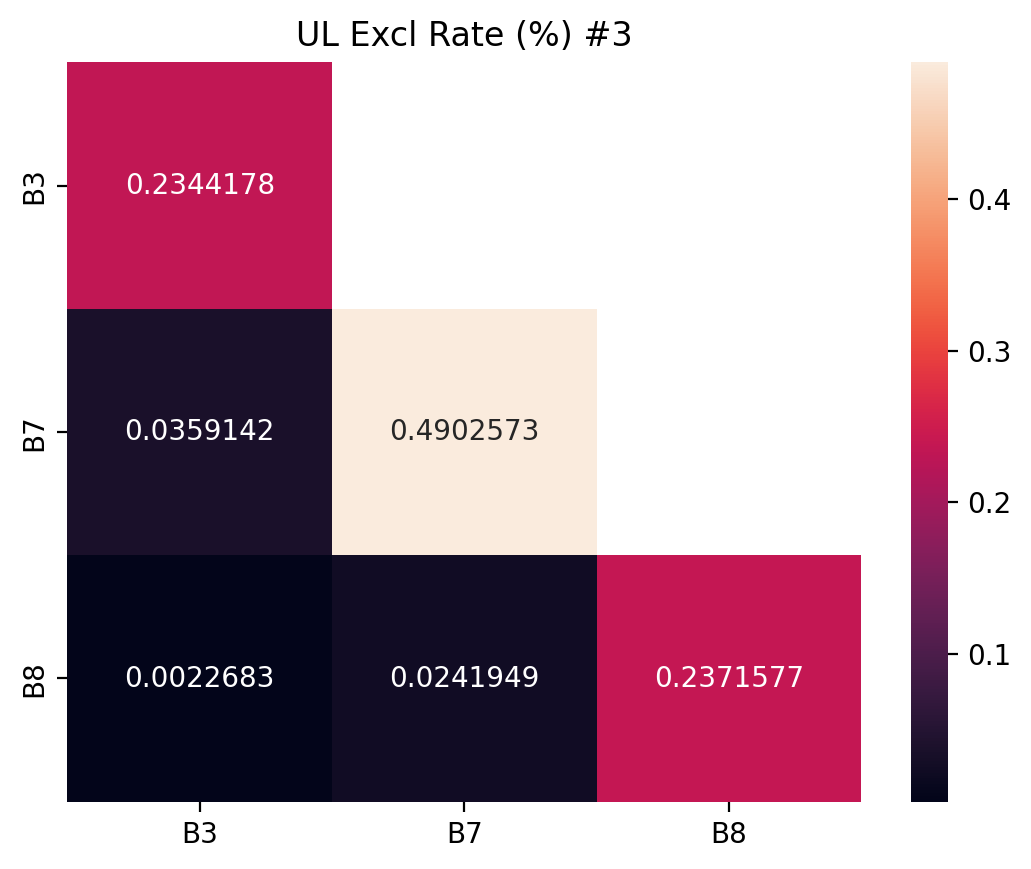

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7
251131,261132,2023-02-04 16:24:59.130719,stable,stable,stable,stable


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8
46849,56850,2023-02-04 16:18:10.517696,stable,stable,stable,stable


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8
148360,158361,2023-02-04 16:21:33.564056,after,MN_HO,after,MN_HO


In [98]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_uplk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Loss Rate (%) #3')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Excl Rate (%) #3')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

{'B3': 0.0385182, 'B7': 0.0422458, 'B8': 0.0410033, 'B3_B7': 0.0008283, 'B3_B8': 0.0004142, 'B7_B8': 0.0004142}


,B3,B7,B8
B3,0.038518,0.000828,0.000414
B7,0.000000,0.042246,0.000414
B8,0.000000,0.000000,0.041003


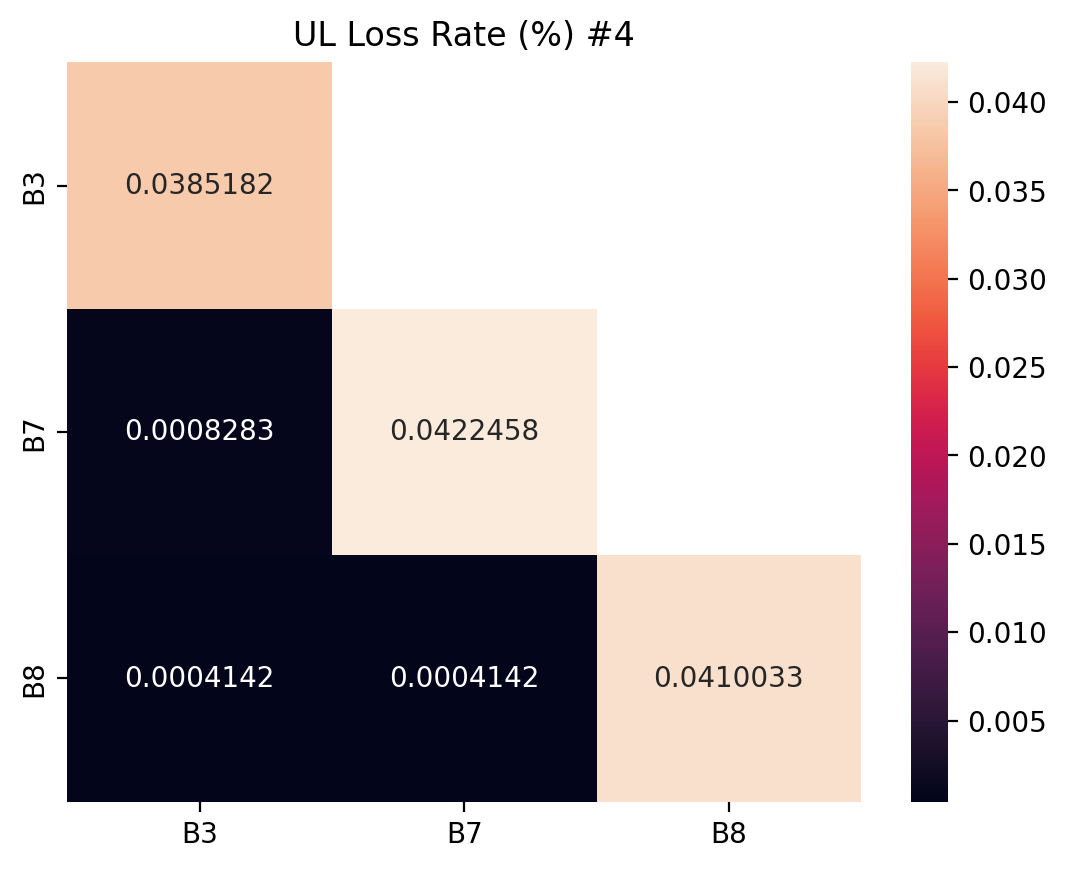

{'B3': 0.2734606, 'B7': 0.6343695, 'B8': 0.4168307, 'B3_B7': 0.0654401, 'B3_B8': 0.0178096, 'B7_B8': 0.0604698}


,B3,B7,B8
B3,0.273461,0.06544,0.017810
B7,0.000000,0.63437,0.060470
B8,0.000000,0.00000,0.416831


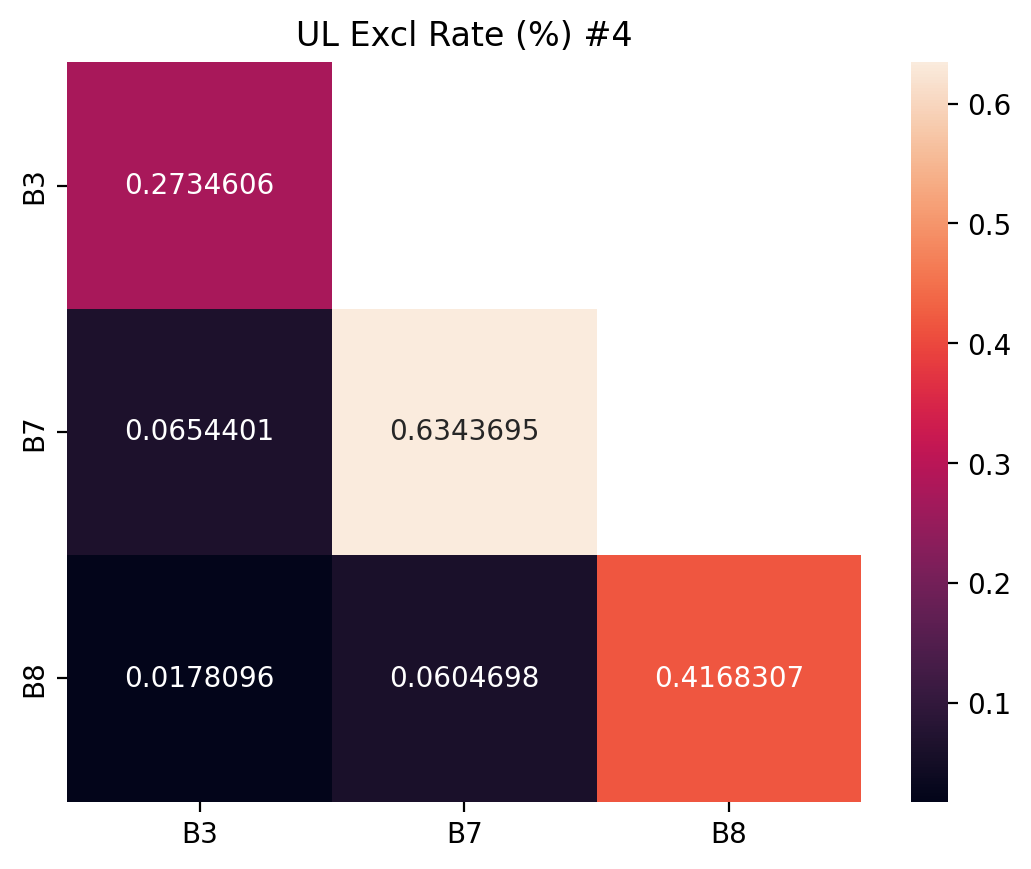

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7
64701,80278,2023-02-04 16:33:54.242754,after,MCG_Failure,after,SN_Setup
124764,140341,2023-02-04 16:35:54.383167,stable,stable,stable,stable


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8
124764,140341,2023-02-04 16:35:54.383167,stable,stable,stable,stable


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8
124764,140341,2023-02-04 16:35:54.383167,stable,stable,stable,stable


In [99]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_uplk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Loss Rate (%) #4')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('UL Excl Rate (%) #4')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

## DL Loss / Excl

{'B3': 0.3489057, 'B7': 0.1022807, 'B8': 0.4635841, 'B3_B7': 0.0, 'B3_B8': 0.0, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.348906,0.000000,0.000000
B7,0.000000,0.102281,0.000000
B8,0.000000,0.000000,0.463584


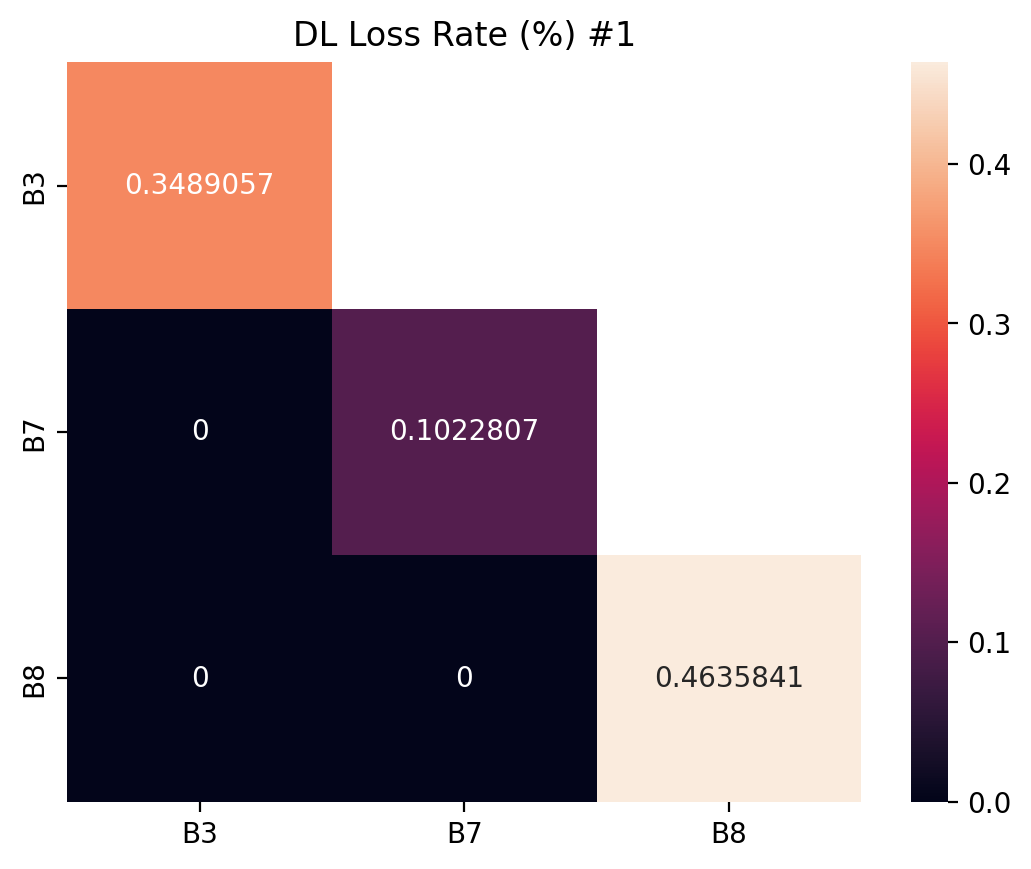

{'B3': 0.2874776, 'B7': 0.9334362, 'B8': 0.2753534, 'B3_B7': 0.0278947, 'B3_B8': 0.0119549, 'B7_B8': 0.1208772}


,B3,B7,B8
B3,0.287478,0.027895,0.011955
B7,0.000000,0.933436,0.120877
B8,0.000000,0.000000,0.275353


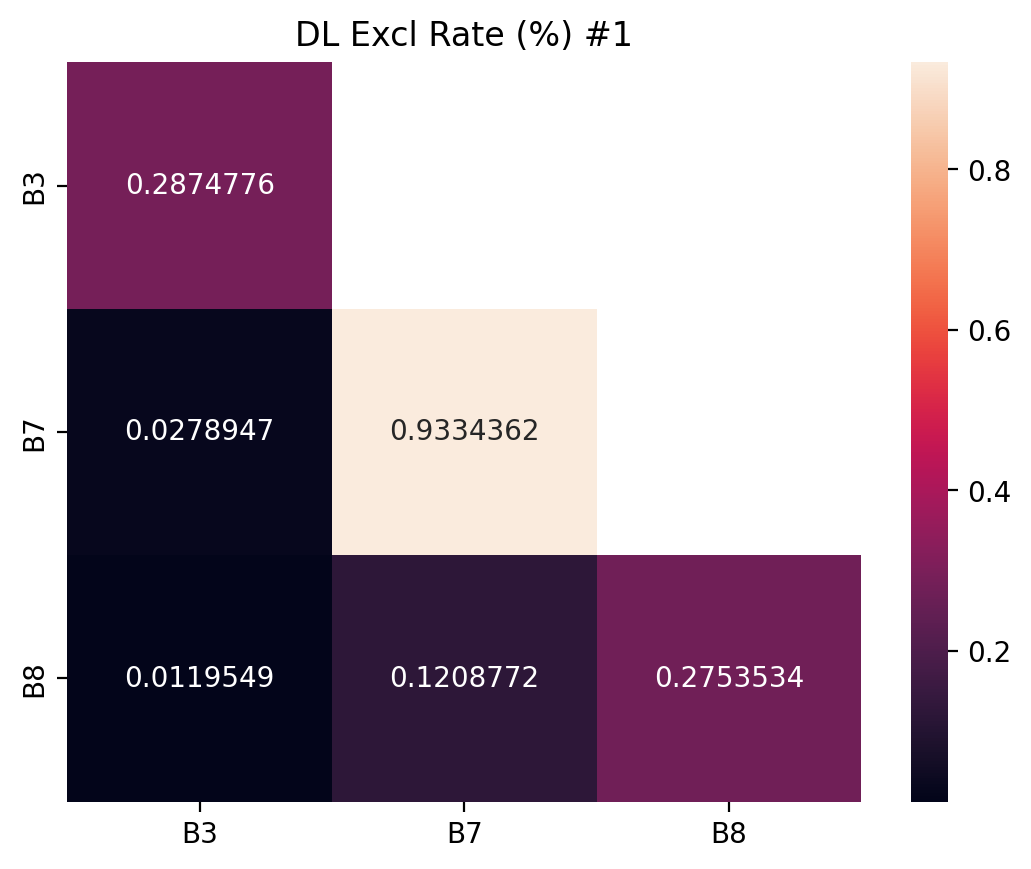

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


In [100]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_dnlk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Loss Rate (%) #1')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Excl Rate (%) #1')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

{'B3': 0.1592684, 'B7': 0.8862399, 'B8': 0.0283144, 'B3_B7': 0.0, 'B3_B8': 0.0, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.159268,0.00000,0.000000
B7,0.000000,0.88624,0.000000
B8,0.000000,0.00000,0.028314


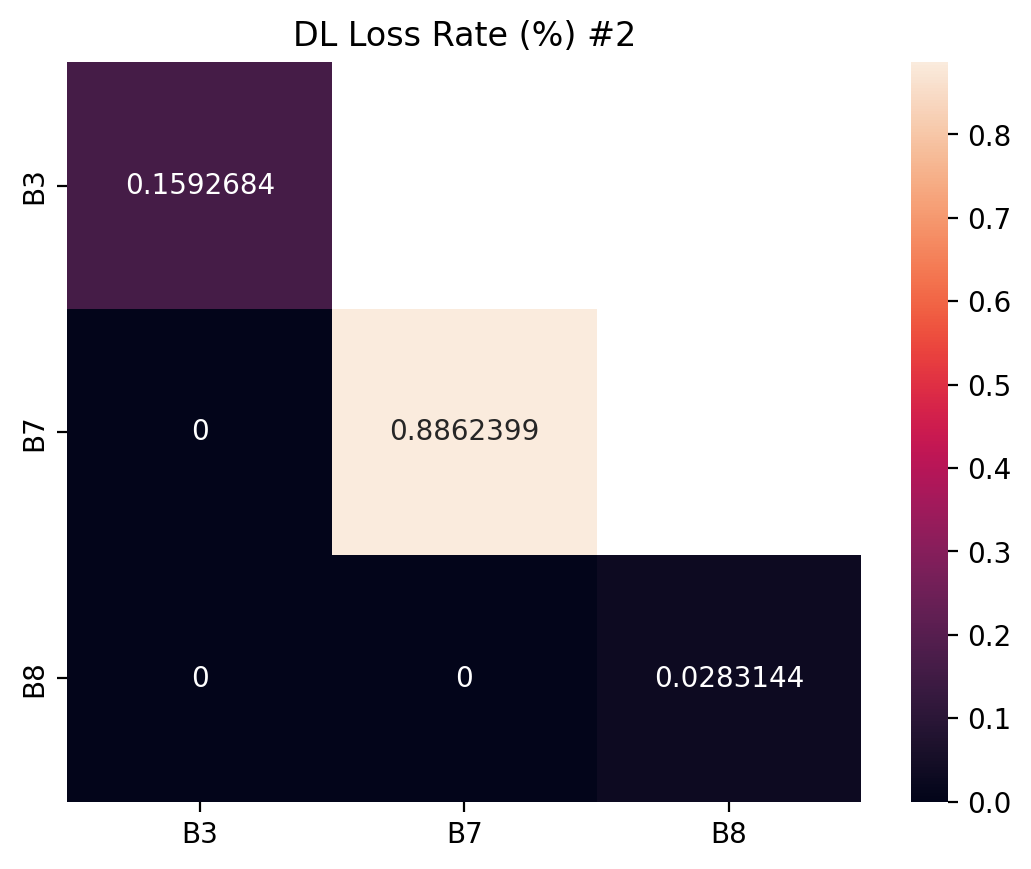

{'B3': 0.2233314, 'B7': 0.3056728, 'B8': 0.3540299, 'B3_B7': 0.0, 'B3_B8': 0.0014157, 'B7_B8': 0.0863588}


,B3,B7,B8
B3,0.223331,0.000000,0.001416
B7,0.000000,0.305673,0.086359
B8,0.000000,0.000000,0.354030


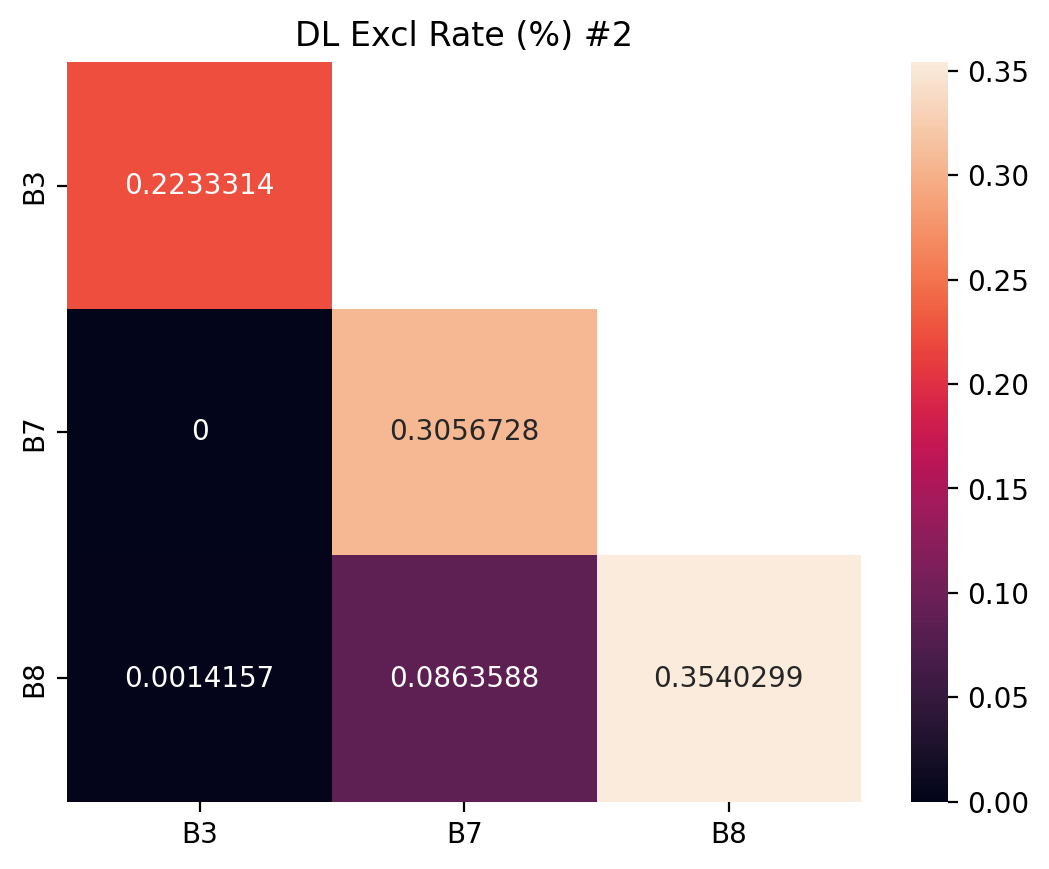

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


In [101]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Loss Rate (%) #2')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Excl Rate (%) #2')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

{'B3': 0.376153, 'B7': 0.934901, 'B8': 0.2994103, 'B3_B7': 0.1255104, 'B3_B8': 0.0, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.376153,0.125510,0.00000
B7,0.000000,0.934901,0.00000
B8,0.000000,0.000000,0.29941


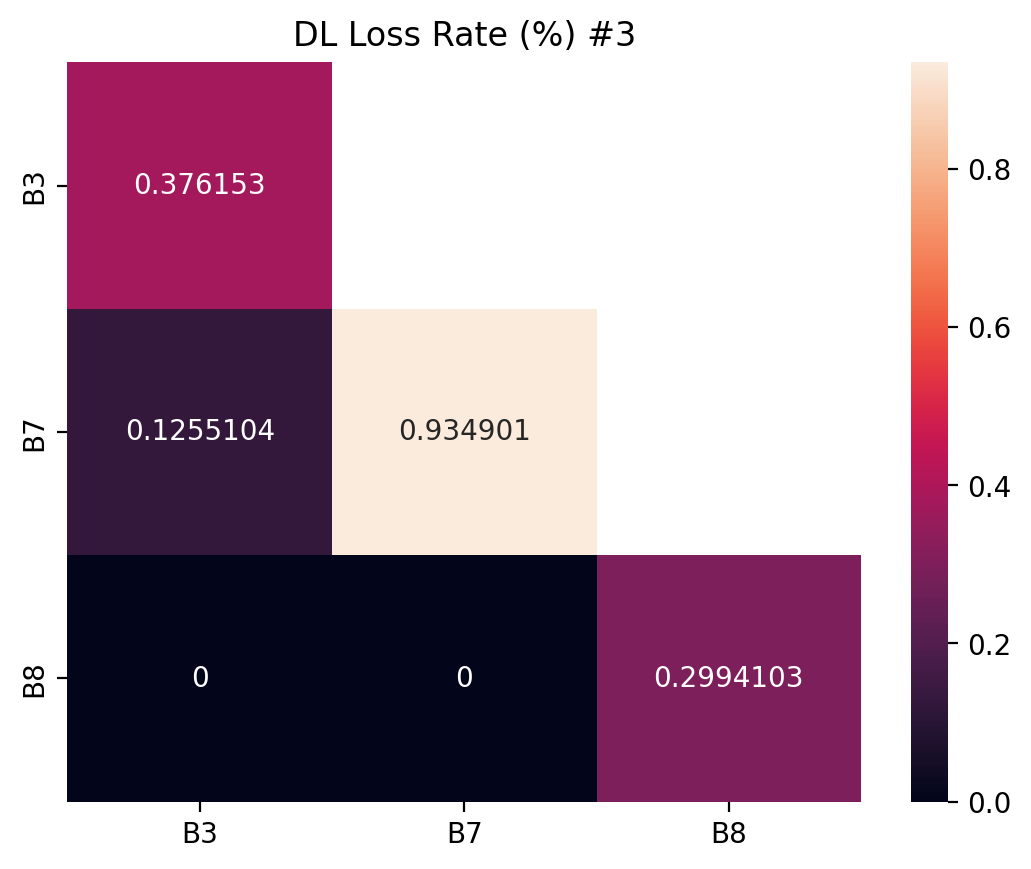

{'B3': 0.3142017, 'B7': 0.2602587, 'B8': 0.3367106, 'B3_B7': 0.0420155, 'B3_B8': 0.0034024, 'B7_B8': 0.0487676}


,B3,B7,B8
B3,0.314202,0.042015,0.003402
B7,0.000000,0.260259,0.048768
B8,0.000000,0.000000,0.336711


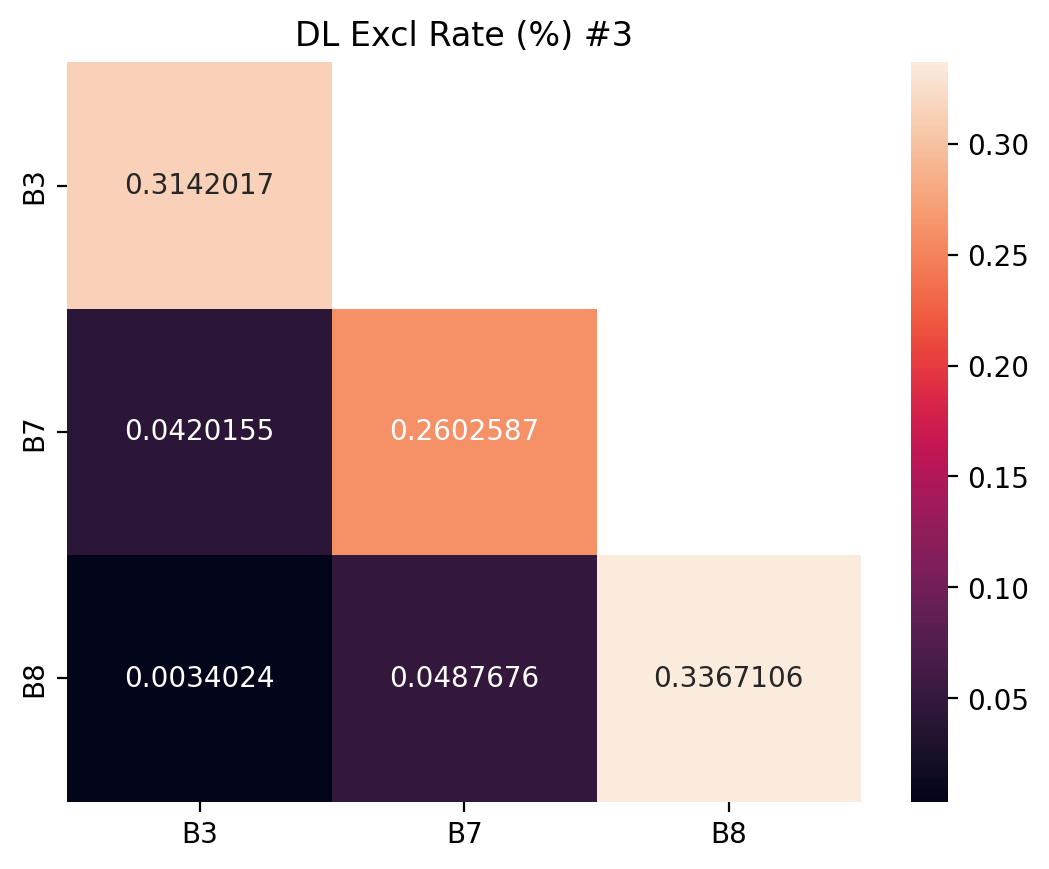

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7
87138,97139,2023-02-04 16:19:31.130890,before,MN_HO,before,NAS_Recovery
87139,97140,2023-02-04 16:19:31.132890,before,MN_HO,before,NAS_Recovery
87140,97141,2023-02-04 16:19:31.134890,before,MN_HO,before,NAS_Recovery
87141,97142,2023-02-04 16:19:31.136890,before,MN_HO,before,NAS_Recovery
87142,97143,2023-02-04 16:19:31.138890,before,MN_HO,before,NAS_Recovery
...,...,...,...,...,...,...
87465,97466,2023-02-04 16:19:31.784921,after,MN_HO,before,NAS_Recovery
87466,97467,2023-02-04 16:19:31.786921,after,MN_HO,before,NAS_Recovery
87467,97468,2023-02-04 16:19:31.788921,after,MN_HO,before,NAS_Recovery
87468,97469,2023-02-04 16:19:31.790921,after,MN_HO,before,NAS_Recovery


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


ho_state_B3  ho_type_B3  ho_state_B7  ho_type_B7  
after        MN_HO       before       NAS_Recovery    210
before       MN_HO       before       NAS_Recovery    113
during       MN_HO       before       NAS_Recovery      9
dtype: int64

,sequence_num,Timestamp,lost_B3,excl_B3,latency_B3,transmit_time_B3,arrival_time_B3,ho_index_B3,ho_state_B3,ho_type_B3,ho_type1_B3,ho_type2_B3,ho_fcause_B3,ho_interrupt_B3,ho_ePCI_B3,ho_earfcn_B3,ho_nrPCI_B3,ho_ePCI1_B3,ho_earfcn1_B3,ho_nrPCI1_B3,lost_B7,excl_B7,latency_B7,transmit_time_B7,arrival_time_B7,ho_index_B7,ho_state_B7,ho_type_B7,ho_type1_B7,ho_type2_B7,ho_fcause_B7,ho_interrupt_B7,ho_ePCI_B7,ho_earfcn_B7,ho_nrPCI_B7,ho_ePCI1_B7,ho_earfcn1_B7,ho_nrPCI1_B7,lost_B8,excl_B8,latency_B8,transmit_time_B8,arrival_time_B8,ho_index_B8,ho_state_B8,ho_type_B8,ho_type1_B8,ho_type2_B8,ho_fcause_B8,ho_interrupt_B8,ho_ePCI_B8,ho_earfcn_B8,ho_nrPCI_B8,ho_ePCI1_B8,ho_earfcn1_B8,ho_nrPCI1_B8,lost_B3_B7,excl_B3_B7,latency_B3_B7,lost_B3_B8,excl_B3_B8,latency_B3_B8,lost_B7_B8,excl_B7_B8,latency_B7_B8
87138,97139,2023-02-04 16:19:31.130890,True,True,inf,2023-02-04 16:19:31.130897,2023-02-04 16:19:31.149368,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.130900,2023-02-04 16:19:31.155412,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.024195,2023-02-04 16:19:31.130904,2023-02-04 16:19:31.155085,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,False,False,0.024195,False,False,0.024195
87139,97140,2023-02-04 16:19:31.132890,True,True,inf,2023-02-04 16:19:31.132898,2023-02-04 16:19:31.151374,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.132901,2023-02-04 16:19:31.157443,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.022201,2023-02-04 16:19:31.132905,2023-02-04 16:19:31.155091,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,False,False,0.022201,False,False,0.022201
87140,97141,2023-02-04 16:19:31.134890,True,True,inf,2023-02-04 16:19:31.134898,2023-02-04 16:19:31.153380,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.134901,2023-02-04 16:19:31.159476,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.020202,2023-02-04 16:19:31.134904,2023-02-04 16:19:31.155092,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,False,False,0.020202,False,False,0.020202
87141,97142,2023-02-04 16:19:31.136890,True,True,inf,2023-02-04 16:19:31.136899,2023-02-04 16:19:31.155388,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.136902,2023-02-04 16:19:31.161508,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.024178,2023-02-04 16:19:31.136906,2023-02-04 16:19:31.161068,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,False,False,0.024178,False,False,0.024178
87142,97143,2023-02-04 16:19:31.138890,True,True,inf,2023-02-04 16:19:31.138898,2023-02-04 16:19:31.157394,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.138901,2023-02-04 16:19:31.163541,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.028280,2023-02-04 16:19:31.138904,2023-02-04 16:19:31.167170,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,False,False,0.028280,False,False,0.028280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150669,160670,2023-02-04 16:21:38.198828,True,True,inf,2023-02-04 16:21:38.198833,2023-02-04 16:21:38.267931,25,after,SN_Setup,NaN,NaN,NaN,0.017357,11,1750,<NA>,<NA>,<NA>,11,False,False,0.032475,2023-02-04 16:21:38.198836,202

ho_state_B3  ho_type_B3 
before       MCG_Failure    374
after        MN_HO          211
             MCG_Failure    130
before       MN_HO          113
after        SN_Setup       109
during       MCG_Failure     38
             MN_HO            9
             SN_Setup         8
stable       stable           3
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7  
before       MCG_Failure  stable       stable          374
after        MN_HO        before       NAS_Recovery    210
             MCG_Failure  stable       stable          130
before       MN_HO        before       NAS_Recovery    113
after        SN_Setup     stable       stable          109
during       MCG_Failure  stable       stable           38
             MN_HO        before       NAS_Recovery      9
             SN_Setup     stable       stable            8
stable       stable       after        SN_HO             2
after        MN_HO        after        MN_HO             1
stable       stable       before       SN_HO             1
dtype: int64

,sequence_num,Timestamp,lost_B3,excl_B3,latency_B3,transmit_time_B3,arrival_time_B3,ho_index_B3,ho_state_B3,ho_type_B3,ho_type1_B3,ho_type2_B3,ho_fcause_B3,ho_interrupt_B3,ho_ePCI_B3,ho_earfcn_B3,ho_nrPCI_B3,ho_ePCI1_B3,ho_earfcn1_B3,ho_nrPCI1_B3,lost_B7,excl_B7,latency_B7,transmit_time_B7,arrival_time_B7,ho_index_B7,ho_state_B7,ho_type_B7,ho_type1_B7,ho_type2_B7,ho_fcause_B7,ho_interrupt_B7,ho_ePCI_B7,ho_earfcn_B7,ho_nrPCI_B7,ho_ePCI1_B7,ho_earfcn1_B7,ho_nrPCI1_B7,lost_B8,excl_B8,latency_B8,transmit_time_B8,arrival_time_B8,ho_index_B8,ho_state_B8,ho_type_B8,ho_type1_B8,ho_type2_B8,ho_fcause_B8,ho_interrupt_B8,ho_ePCI_B8,ho_earfcn_B8,ho_nrPCI_B8,ho_ePCI1_B8,ho_earfcn1_B8,ho_nrPCI1_B8,lost_B3_B7,excl_B3_B7,latency_B3_B7,lost_B3_B8,excl_B3_B8,latency_B3_B8,lost_B7_B8,excl_B7_B8,latency_B7_B8
87114,97115,2023-02-04 16:19:31.082888,False,False,0.022431,2023-02-04 16:19:31.082895,2023-02-04 16:19:31.105319,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.082898,2023-02-04 16:19:31.106641,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.024148,2023-02-04 16:19:31.082902,2023-02-04 16:19:31.107036,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.022431,False,False,0.022431,False,False,0.024148
87115,97116,2023-02-04 16:19:31.084888,False,False,0.020472,2023-02-04 16:19:31.084896,2023-02-04 16:19:31.105360,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.084899,2023-02-04 16:19:31.108673,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.028150,2023-02-04 16:19:31.084903,2023-02-04 16:19:31.113038,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.020472,False,False,0.020472,False,False,0.028150
87116,97117,2023-02-04 16:19:31.086888,False,False,0.024431,2023-02-04 16:19:31.086895,2023-02-04 16:19:31.111319,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.086899,2023-02-04 16:19:31.110705,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.026210,2023-02-04 16:19:31.086902,2023-02-04 16:19:31.113098,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.024431,False,False,0.024431,False,False,0.026210
87117,97118,2023-02-04 16:19:31.088888,False,False,0.022435,2023-02-04 16:19:31.088896,2023-02-04 16:19:31.111323,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.088900,2023-02-04 16:19:31.112737,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.024213,2023-02-04 16:19:31.088903,2023-02-04 16:19:31.113101,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.022435,False,False,0.022435,False,False,0.024213
87118,97119,2023-02-04 16:19:31.090888,False,False,0.020470,2023-02-04 16:19:31.090895,2023-02-04 16:19:31.111358,7,before,MN_HO,intra_freq,inter_enb,NaN,0.018926,266,1750,186,186,1750,<NA>,True,True,inf,2023-02-04 16:19:31.090899,2023-02-04 16:19:31.114769,13,before,NAS_Recovery,NaN,NaN,otherFailure (2),0.155026,186,3050,186,274,<NA>,<NA>,False,False,0.022214,2023-02-04 16:19:31.090902,2023-02-04 16:19:31.113102,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.020470,False,False,0.020470,False,False,0.022214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213498,223499,2023-02-04 16:23:43.862700,False,False,0.048516,2023-02-04 16:23:43.862707,2023-02-04 16:23:43.911216,35,after,MN_HO,intra_freq,inter_enb,NaN

ho_state_B7  ho_type_B7  
before       NAS_Recovery    847
             MCG_Failure     546
after        MN_HO           314
             NAS_Recovery    247
             MCG_Failure     176
before       MN_HO           141
during       NAS_Recovery     77
             MCG_Failure      38
             SN_Setup         37
after        SN_Setup         35
during       MN_HO             8
after        SN_HO             4
before       SN_HO             3
dtype: int64

ho_state_B3  ho_type_B3  ho_state_B7  ho_type_B7  
after        MN_HO       before       NAS_Recovery    498
before       SN_Rel      before       MCG_Failure     285
stable       stable      after        NAS_Recovery    247
                         before       NAS_Recovery    203
after        MN_HO       after        MN_HO           200
before       SN_Rel      before       MN_HO           141
after        SN_Setup    after        MCG_Failure     138
before       MN_HO       before       NAS_Recovery    137
stable       stable      after        MN_HO           114
before       SN_Setup    before       MCG_Failure      78
stable       stable      during       NAS_Recovery     77
after        SN_Rel      before       MCG_Failure      76
             SN_Setup    before       MCG_Failure      72
                         during       MCG_Failure      38
before       SN_HO       after        MCG_Failure      38
                                      SN_Setup         35
                     

In [102]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_dnlk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Loss Rate (%) #3')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Excl Rate (%) #3')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

display(df.loc[df['lost_B3'] == True, :])
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']].value_counts())
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B7'] == True, :])
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

{'B3': 0.0778648, 'B7': 0.9820083, 'B8': 0.3400374, 'B3_B7': 0.0459734, 'B3_B8': 0.0, 'B7_B8': 0.0}


,B3,B7,B8
B3,0.077865,0.045973,0.000000
B7,0.000000,0.982008,0.000000
B8,0.000000,0.000000,0.340037


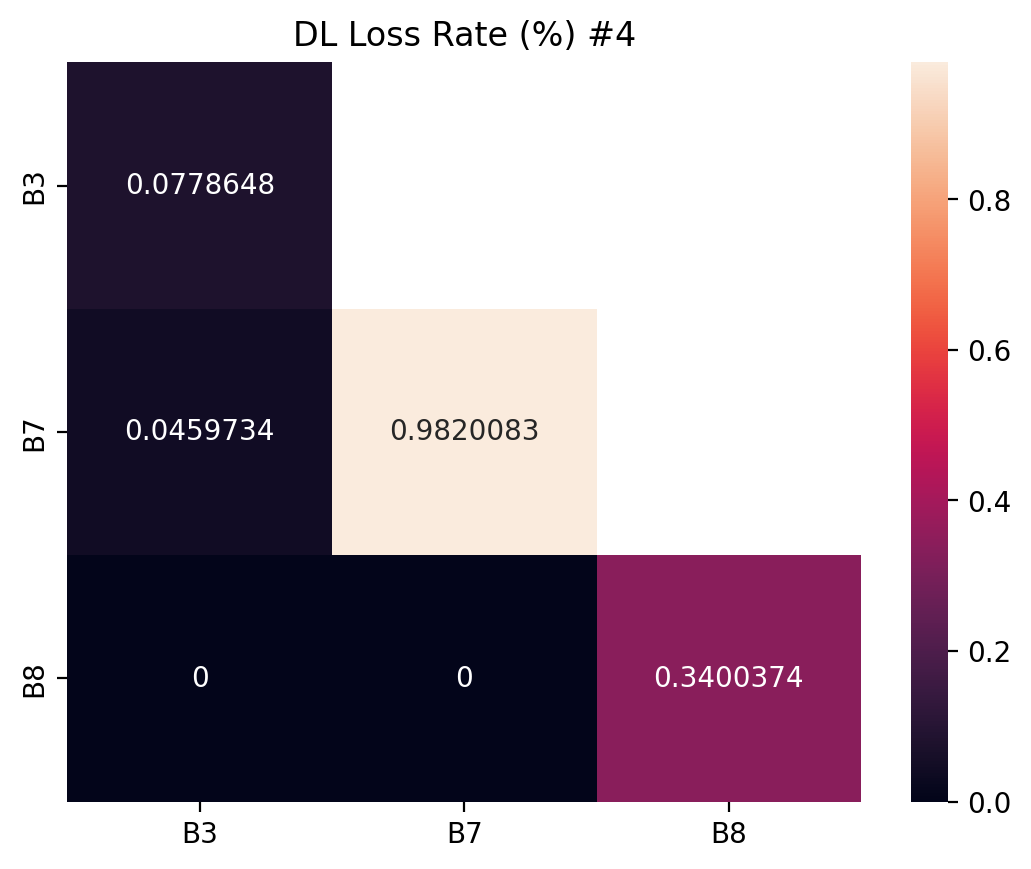

{'B3': 0.5616441, 'B7': 0.3655787, 'B8': 0.4022891, 'B3_B7': 0.0629835, 'B3_B8': 0.0244363, 'B7_B8': 0.0124252}


,B3,B7,B8
B3,0.561644,0.062983,0.024436
B7,0.000000,0.365579,0.012425
B8,0.000000,0.000000,0.402289


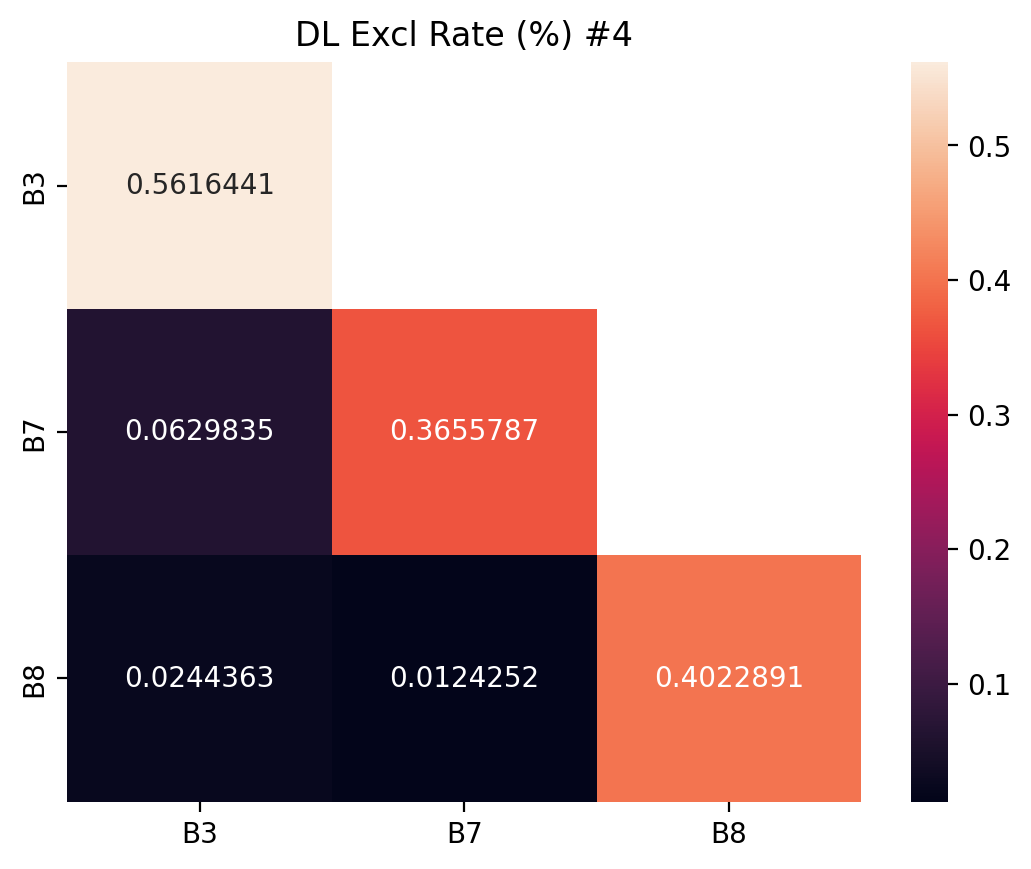

,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B7,ho_type_B7
64442,80019,2023-02-04 16:33:53.745121,before,MCG_Failure,after,SN_Setup
64443,80020,2023-02-04 16:33:53.747121,before,MCG_Failure,after,SN_Setup
64444,80021,2023-02-04 16:33:53.749121,before,MCG_Failure,after,SN_Setup
64445,80022,2023-02-04 16:33:53.751121,before,MCG_Failure,after,SN_Setup
64446,80023,2023-02-04 16:33:53.753121,before,MCG_Failure,after,SN_Setup
...,...,...,...,...,...,...
64548,80125,2023-02-04 16:33:53.957131,after,MCG_Failure,after,SN_Setup
64549,80126,2023-02-04 16:33:53.959131,after,MCG_Failure,after,SN_Setup
64550,80127,2023-02-04 16:33:53.961131,after,MCG_Failure,after,SN_Setup
64551,80128,2023-02-04 16:33:53.963131,after,MCG_Failure,after,SN_Setup


,sequence_num,Timestamp,ho_state_B3,ho_type_B3,ho_state_B8,ho_type_B8


,sequence_num,Timestamp,ho_state_B7,ho_type_B7,ho_state_B8,ho_type_B8


ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
after        MCG_Failure  after        SN_Setup      62
during       MCG_Failure  after        SN_Setup      26
before       MCG_Failure  after        SN_Setup      23
dtype: int64

,sequence_num,Timestamp,lost_B3,excl_B3,latency_B3,transmit_time_B3,arrival_time_B3,ho_index_B3,ho_state_B3,ho_type_B3,ho_type1_B3,ho_type2_B3,ho_fcause_B3,ho_interrupt_B3,ho_ePCI_B3,ho_earfcn_B3,ho_nrPCI_B3,ho_ePCI1_B3,ho_earfcn1_B3,ho_nrPCI1_B3,lost_B7,excl_B7,latency_B7,transmit_time_B7,arrival_time_B7,ho_index_B7,ho_state_B7,ho_type_B7,ho_type1_B7,ho_type2_B7,ho_fcause_B7,ho_interrupt_B7,ho_ePCI_B7,ho_earfcn_B7,ho_nrPCI_B7,ho_ePCI1_B7,ho_earfcn1_B7,ho_nrPCI1_B7,lost_B8,excl_B8,latency_B8,transmit_time_B8,arrival_time_B8,ho_index_B8,ho_state_B8,ho_type_B8,ho_type1_B8,ho_type2_B8,ho_fcause_B8,ho_interrupt_B8,ho_ePCI_B8,ho_earfcn_B8,ho_nrPCI_B8,ho_ePCI1_B8,ho_earfcn1_B8,ho_nrPCI1_B8,lost_B3_B7,excl_B3_B7,latency_B3_B7,lost_B3_B8,excl_B3_B8,latency_B3_B8,lost_B7_B8,excl_B7_B8,latency_B7_B8
62505,78082,2023-02-04 16:33:49.870940,True,True,inf,2023-02-04 16:33:49.870947,2023-02-04 16:33:50.003135,4,after,LTE_HO,intra_freq,inter_enb,NaN,0.033888,73,1750,<NA>,378,1750,<NA>,False,False,0.017755,2023-02-04 16:33:49.870951,2023-02-04 16:33:49.888695,7,after,MN_HO,intra_freq,inter_enb,NaN,0.016038,73,3050,370,370,3050,<NA>,False,False,0.021529,2023-02-04 16:33:49.870954,2023-02-04 16:33:49.892469,14,after,MN_HO,intra_freq,inter_sector,NaN,0.015681,362,3650,370,370,3650,<NA>,False,False,0.017755,False,False,0.021529,False,False,0.017755
62506,78083,2023-02-04 16:33:49.872940,True,True,inf,2023-02-04 16:33:49.872948,2023-02-04 16:33:50.003135,4,after,LTE_HO,intra_freq,inter_enb,NaN,0.033888,73,1750,<NA>,378,1750,<NA>,False,False,0.021746,2023-02-04 16:33:49.872952,2023-02-04 16:33:49.894686,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.019531,2023-02-04 16:33:49.872956,2023-02-04 16:33:49.892471,14,after,MN_HO,intra_freq,inter_sector,NaN,0.015681,362,3650,370,370,3650,<NA>,False,False,0.021746,False,False,0.019531,False,False,0.019531
62507,78084,2023-02-04 16:33:49.874940,True,True,inf,2023-02-04 16:33:49.874955,2023-02-04 16:33:50.003135,4,after,LTE_HO,intra_freq,inter_enb,NaN,0.033888,73,1750,<NA>,378,1750,<NA>,False,False,0.019758,2023-02-04 16:33:49.874992,2023-02-04 16:33:49.894698,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.017533,2023-02-04 16:33:49.875118,2023-02-04 16:33:49.892473,14,after,MN_HO,intra_freq,inter_sector,NaN,0.015681,362,3650,370,370,3650,<NA>,False,False,0.019758,False,False,0.017533,False,False,0.017533
62508,78085,2023-02-04 16:33:49.876940,True,True,inf,2023-02-04 16:33:49.876958,2023-02-04 16:33:50.003135,4,after,LTE_HO,intra_freq,inter_enb,NaN,0.033888,73,1750,<NA>,378,1750,<NA>,False,False,0.017760,2023-02-04 16:33:49.876982,2023-02-04 16:33:49.894700,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.015534,2023-02-04 16:33:49.877000,2023-02-04 16:33:49.892474,14,after,MN_HO,intra_freq,inter_sector,NaN,0.015681,362,3650,370,370,3650,<NA>,False,False,0.017760,False,False,0.015534,False,False,0.015534
62509,78086,2023-02-04 16:33:49.878940,True,True,inf,2023-02-04 16:33:49.878955,2023-02-04 16:33:50.003136,4,after,LTE_HO,intra_freq,inter_enb,NaN,0.033888,73,1750,<NA>,378,1750,<NA>,False,False,0.021739,2023-02-04 16:33:49.878991,2023-02-04 16:33:49.900679,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.019576,2023-02-04 16:33:49.879008,2023-02-04 16:33:49.898516,14,after,MN_HO,intra_freq,inter_sector,NaN,0.015681,362,3650,370,370,3650,<NA>,False,False,0.021739,False,False,0.019576,False,False,0.019576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64548,80125,2023-02-04 16:33:53.957131,True,True,inf,2023-02-04 16:33:53.957136,2023-02-04 16:33:54.030010,6,after,MCG_Failure,NaN,NaN,otherFailure (2),0.059379,73,1400,370,378,<NA>,

ho_state_B3  ho_type_B3 
before       MCG_Failure    77
after        MCG_Failure    62
during       MCG_Failure    26
after        LTE_HO         23
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
before       MCG_Failure  after        SN_Setup      77
after        MCG_Failure  after        SN_Setup      62
during       MCG_Failure  after        SN_Setup      26
after        LTE_HO       stable       stable        22
                          after        MN_HO          1
dtype: int64

,sequence_num,Timestamp,lost_B3,excl_B3,latency_B3,transmit_time_B3,arrival_time_B3,ho_index_B3,ho_state_B3,ho_type_B3,ho_type1_B3,ho_type2_B3,ho_fcause_B3,ho_interrupt_B3,ho_ePCI_B3,ho_earfcn_B3,ho_nrPCI_B3,ho_ePCI1_B3,ho_earfcn1_B3,ho_nrPCI1_B3,lost_B7,excl_B7,latency_B7,transmit_time_B7,arrival_time_B7,ho_index_B7,ho_state_B7,ho_type_B7,ho_type1_B7,ho_type2_B7,ho_fcause_B7,ho_interrupt_B7,ho_ePCI_B7,ho_earfcn_B7,ho_nrPCI_B7,ho_ePCI1_B7,ho_earfcn1_B7,ho_nrPCI1_B7,lost_B8,excl_B8,latency_B8,transmit_time_B8,arrival_time_B8,ho_index_B8,ho_state_B8,ho_type_B8,ho_type1_B8,ho_type2_B8,ho_fcause_B8,ho_interrupt_B8,ho_ePCI_B8,ho_earfcn_B8,ho_nrPCI_B8,ho_ePCI1_B8,ho_earfcn1_B8,ho_nrPCI1_B8,lost_B3_B7,excl_B3_B7,latency_B3_B7,lost_B3_B8,excl_B3_B8,latency_B3_B8,lost_B7_B8,excl_B7_B8,latency_B7_B8
18870,34447,2023-02-04 16:32:22.596862,False,False,0.012272,2023-02-04 16:32:22.596926,2023-02-04 16:32:22.609134,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,2023-02-04 16:32:22.597033,2023-02-04 16:32:22.609238,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.016180,2023-02-04 16:32:22.597048,2023-02-04 16:32:22.613042,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,False,0.012272,False,False,0.012272,False,False,0.016180
64442,80019,2023-02-04 16:33:53.745121,True,True,inf,2023-02-04 16:33:53.745127,2023-02-04 16:33:53.780451,6,before,MCG_Failure,NaN,NaN,otherFailure (2),0.059379,73,1400,370,378,<NA>,<NA>,True,True,inf,2023-02-04 16:33:53.745130,2023-02-04 16:33:53.767300,9,after,SN_Setup,NaN,NaN,NaN,0.044392,73,3050,<NA>,<NA>,<NA>,73,False,False,0.026247,2023-02-04 16:33:53.745134,2023-02-04 16:33:53.771368,16,after,MN_HO,intra_freq,inter_enb,NaN,0.015455,370,3650,73,49,3650,<NA>,True,True,inf,False,False,0.026247,False,False,0.026247
64443,80020,2023-02-04 16:33:53.747121,True,True,inf,2023-02-04 16:33:53.747127,2023-02-04 16:33:53.782806,6,before,MCG_Failure,NaN,NaN,otherFailure (2),0.059379,73,1400,370,378,<NA>,<NA>,True,True,inf,2023-02-04 16:33:53.747131,2023-02-04 16:33:53.769638,9,after,SN_Setup,NaN,NaN,NaN,0.044392,73,3050,<NA>,<NA>,<NA>,73,False,False,0.024249,2023-02-04 16:33:53.747134,2023-02-04 16:33:53.771370,16,after,MN_HO,intra_freq,inter_enb,NaN,0.015455,370,3650,73,49,3650,<NA>,True,True,inf,False,False,0.024249,False,False,0.024249
64444,80021,2023-02-04 16:33:53.749121,True,True,inf,2023-02-04 16:33:53.749131,2023-02-04 16:33:53.785160,6,before,MCG_Failure,NaN,NaN,otherFailure (2),0.059379,73,1400,370,378,<NA>,<NA>,True,True,inf,2023-02-04 16:33:53.749201,2023-02-04 16:33:53.771976,9,after,SN_Setup,NaN,NaN,NaN,0.044392,73,3050,<NA>,<NA>,<NA>,73,False,False,0.022250,2023-02-04 16:33:53.749294,2023-02-04 16:33:53.771371,16,after,MN_HO,intra_freq,inter_enb,NaN,0.015455,370,3650,73,49,3650,<NA>,True,True,inf,False,False,0.022250,False,False,0.022250
64445,80022,2023-02-04 16:33:53.751121,True,True,inf,2023-02-04 16:33:53.751160,2023-02-04 16:33:53.787514,6,before,MCG_Failure,NaN,NaN,otherFailure (2),0.059379,73,1400,370,378,<NA>,<NA>,True,True,inf,2023-02-04 16:33:53.751184,2023-02-04 16:33:53.774315,9,after,SN_Setup,NaN,NaN,NaN,0.044392,73,3050,<NA>,<NA>,<NA>,73,False,False,0.020252,2023-02-04 16:33:53.751227,2023-02-04 16:33:53.771373,16,after,MN_HO,intra_freq,inter_enb,NaN,0.015455,370,3650,73,49,3650,<NA>,True,True,inf,False,False,0.020252,False,False,0.020252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197270,212847,2023-02-04 16:38:19.413535,False,False,0.046471,2023-02-04 16:38:19.413542,2023-02-04 16:38:19.460006,-1,stable,stable,stable,stable,no failure,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,True,inf,2023-02-04 16:38:19.413545,2023-02-04 16:38:19.453343,45,after,MN_HO,intra_freq,i

ho_state_B7  ho_type_B7 
after        SN_Setup       698
before       MCG_Failure    683
after        MN_HO          427
             MCG_Failure    200
before       MN_HO          131
             SN_HO           79
during       MCG_Failure     65
             SN_Setup        38
after        SN_HO           24
during       MN_HO           16
             SN_HO            8
stable       stable           2
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7 
stable       stable       after        MN_HO          231
                          before       MCG_Failure    227
before       MN_HO        before       MCG_Failure    225
after        MN_HO        after        SN_Setup       197
             SN_HO        after        MN_HO          149
stable       stable       after        SN_Setup       126
before       MN_HO        after        SN_Setup       110
                                       MCG_Failure    108
after        SN_Setup     after        SN_Setup       107
                          before       MN_HO          106
             MCG_Failure  after        SN_Setup        98
             SN_Setup     after        MCG_Failure     92
                          before       MCG_Failure     92
before       SN_Setup     before       MCG_Failure     82
after        SN_HO        before       SN_HO           69
             SN_Setup     after        MN_HO           47
before       MN_HO   

In [109]:
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency_ho.pkl")

### Loss Rate
loss_r_dict = {}
for tag in tags:
    loss_r = round(df[f'lost_{tag}'].sum() / (len(df)+1e-9) * 100, 7)
    loss_r_dict[tag] = loss_r
print(loss_r_dict)
mat = fill_out_matrix(schemes, mtags, loss_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Loss Rate (%) #4')
plt.show()

### Excessive Latency Rate
excl_r_dict = {}
for tag in tags:
    excl_r = round(df.loc[df[f'lost_{tag}'] == False, f'excl_{tag}'].sum() / (len(df[df[f'lost_{tag}'] == False])+1e-9) * 100, 7)
    excl_r_dict[tag] = excl_r
print(excl_r_dict)
mat = fill_out_matrix(schemes, mtags, excl_r_dict)

display(mat)
ax = sns.heatmap(mat.T, annot=True, fmt='.7g', mask=mask(len(schemes)))
ax.set_title('DL Excl Rate (%) #4')
plt.show()

display(df.loc[df['lost_B3_B7'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']])
display(df.loc[df['lost_B3_B8'] == True, ['sequence_num','Timestamp','ho_state_B3','ho_type_B3','ho_state_B8','ho_type_B8']])
display(df.loc[df['lost_B7_B8'] == True, ['sequence_num','Timestamp','ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']])

display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

display(df.loc[df['lost_B3'] == True, :])
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']].value_counts())
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B7'] == True, :])
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

# Trace 3: B3B7, B7B8, DL

In [127]:
pd.set_option('display.max_columns', 200)
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#01/udp_dnlk_combo_loss_latency_ho.pkl")

In [128]:
# display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(len(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']]))
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']].value_counts())
display(df.loc[(df['lost_B3'] == True) & (df['lost_B7'] == False), ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

# display(df.loc[df['lost_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(len(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']]))
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[(df['lost_B7'] == True) & (df['lost_B3'] == False), ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

995

ho_state_B3  ho_type_B3 
before       MCG_Failure    374
after        MN_HO          211
             MCG_Failure    130
before       MN_HO          113
after        SN_Setup       109
during       MCG_Failure     38
             MN_HO            9
             SN_Setup         8
stable       stable           3
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
before       MCG_Failure  stable       stable        374
after        MCG_Failure  stable       stable        130
             SN_Setup     stable       stable        109
during       MCG_Failure  stable       stable         38
             SN_Setup     stable       stable          8
stable       stable       after        SN_HO           2
after        MN_HO        after        MN_HO           1
stable       stable       before       SN_HO           1
dtype: int64

ho_state_B3  ho_type_B3  ho_state_B7  ho_type_B7  
after        MN_HO       before       NAS_Recovery    210
before       MN_HO       before       NAS_Recovery    113
during       MN_HO       before       NAS_Recovery      9
dtype: int64

2473

ho_state_B7  ho_type_B7  
before       NAS_Recovery    847
             MCG_Failure     546
after        MN_HO           314
             NAS_Recovery    247
             MCG_Failure     176
before       MN_HO           141
during       NAS_Recovery     77
             MCG_Failure      38
             SN_Setup         37
after        SN_Setup         35
during       MN_HO             8
after        SN_HO             4
before       SN_HO             3
dtype: int64

ho_state_B3  ho_type_B3  ho_state_B7  ho_type_B7  
after        MN_HO       before       NAS_Recovery    288
before       SN_Rel      before       MCG_Failure     285
stable       stable      after        NAS_Recovery    247
                         before       NAS_Recovery    203
after        MN_HO       after        MN_HO           200
before       SN_Rel      before       MN_HO           141
after        SN_Setup    after        MCG_Failure     138
stable       stable      after        MN_HO           114
before       SN_Setup    before       MCG_Failure      78
stable       stable      during       NAS_Recovery     77
after        SN_Rel      before       MCG_Failure      76
             SN_Setup    before       MCG_Failure      72
                         during       MCG_Failure      38
before       SN_HO       after        MCG_Failure      38
                                      SN_Setup         35
             MN_HO       before       NAS_Recovery     24
             SN_HO   

ho_state_B3  ho_type_B3  ho_state_B7  ho_type_B7  
after        MN_HO       before       NAS_Recovery    210
before       MN_HO       before       NAS_Recovery    113
during       MN_HO       before       NAS_Recovery      9
dtype: int64

In [129]:
# display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(len(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']]))
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[(df['lost_B7'] == True) & (df['lost_B8'] == False), ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[df['lost_B7_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())

# display(df.loc[df['lost_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(len(df.loc[df['lost_B8'] == True, ['ho_state_B8','ho_type_B8']]))
display(df.loc[df['lost_B8'] == True, ['ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[(df['lost_B8'] == True) & (df['lost_B7'] == False), ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[df['lost_B7_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())

2473

ho_state_B7  ho_type_B7  
before       NAS_Recovery    847
             MCG_Failure     546
after        MN_HO           314
             NAS_Recovery    247
             MCG_Failure     176
before       MN_HO           141
during       NAS_Recovery     77
             MCG_Failure      38
             SN_Setup         37
after        SN_Setup         35
during       MN_HO             8
after        SN_HO             4
before       SN_HO             3
dtype: int64

ho_state_B7  ho_type_B7    ho_state_B8  ho_type_B8
before       NAS_Recovery  stable       stable        495
                           before       MN_HO         352
after        MN_HO         stable       stable        200
before       MCG_Failure   after        SN_Setup      189
after        MCG_Failure   after        SN_HO         174
             NAS_Recovery  after        MN_HO         168
before       MCG_Failure   before       SN_HO         151
             MN_HO         before       SN_Rel        141
             MCG_Failure   before       SN_Rel        122
after        MN_HO         before       MN_HO         114
during       NAS_Recovery  before       MN_HO          77
after        NAS_Recovery  before       MN_HO          73
             SN_Setup      after        SN_HO          35
during       MCG_Failure   before       SN_HO          34
before       MCG_Failure   before       SN_Setup       34
                           after        SN_Rel         33
during       SN_Setup

Series([], dtype: int64)

792

ho_state_B8  ho_type_B8
after        SN_Setup      384
             MN_HO         240
stable       stable        166
after        SN_Rel          1
before       SN_Setup        1
dtype: int64

ho_state_B7  ho_type_B7  ho_state_B8  ho_type_B8
before       SN_HO       after        SN_Setup      193
after        MN_HO       after        SN_Setup      161
stable       stable      after        MN_HO          95
after        SN_Setup    after        MN_HO          75
             MN_HO       after        MN_HO          70
stable       stable      stable       stable         65
after        SN_Setup    stable       stable         48
             MN_HO       stable       stable         46
before       MN_HO       after        SN_Setup       21
during       MN_HO       after        SN_Setup        9
before       SN_HO       stable       stable          7
             MN_HO       after        SN_Rel          1
                         before       SN_Setup        1
dtype: int64

Series([], dtype: int64)

# Trace 4: B3B7, B7B8, DL

In [130]:
pd.set_option('display.max_columns', 200)
df = pd.read_pickle("/home/wmnlab/D/database/2023-02-04#1/_Bandlock_Udp_B3_B7_B8_RM500Q/combo/#02/udp_dnlk_combo_loss_latency_ho.pkl")

In [131]:
# display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(len(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']]))
display(df.loc[df['lost_B3'] == True, ['ho_state_B3','ho_type_B3']].value_counts())
display(df.loc[(df['lost_B3'] == True) & (df['lost_B7'] == False), ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

# display(df.loc[df['lost_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(len(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']]))
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[(df['lost_B7'] == True) & (df['lost_B3'] == False), ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[df['lost_B3_B7'] == True, ['ho_state_B3','ho_type_B3','ho_state_B7','ho_type_B7']].value_counts())

188

ho_state_B3  ho_type_B3 
before       MCG_Failure    77
after        MCG_Failure    62
during       MCG_Failure    26
after        LTE_HO         23
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
before       MCG_Failure  after        SN_Setup      54
after        LTE_HO       stable       stable        22
                          after        MN_HO          1
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
after        MCG_Failure  after        SN_Setup      62
during       MCG_Failure  after        SN_Setup      26
before       MCG_Failure  after        SN_Setup      23
dtype: int64

2371

ho_state_B7  ho_type_B7 
after        SN_Setup       698
before       MCG_Failure    683
after        MN_HO          427
             MCG_Failure    200
before       MN_HO          131
             SN_HO           79
during       MCG_Failure     65
             SN_Setup        38
after        SN_HO           24
during       MN_HO           16
             SN_HO            8
stable       stable           2
dtype: int64

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7 
stable       stable       after        MN_HO          231
                          before       MCG_Failure    227
before       MN_HO        before       MCG_Failure    225
after        MN_HO        after        SN_Setup       197
             SN_HO        after        MN_HO          149
stable       stable       after        SN_Setup       126
before       MN_HO        after        SN_Setup       110
                                       MCG_Failure    108
after        SN_Setup     after        SN_Setup       107
                          before       MN_HO          106
                          after        MCG_Failure     92
                          before       MCG_Failure     92
before       SN_Setup     before       MCG_Failure     82
after        SN_HO        before       SN_HO           69
             SN_Setup     after        MN_HO           47
before       MN_HO        during       MCG_Failure     37
after        MCG_Fail

ho_state_B3  ho_type_B3   ho_state_B7  ho_type_B7
after        MCG_Failure  after        SN_Setup      62
during       MCG_Failure  after        SN_Setup      26
before       MCG_Failure  after        SN_Setup      23
dtype: int64

In [132]:
# display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(len(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']]))
display(df.loc[df['lost_B7'] == True, ['ho_state_B7','ho_type_B7']].value_counts())
display(df.loc[(df['lost_B7'] == True) & (df['lost_B8'] == False), ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[df['lost_B7_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())

# display(df.loc[df['lost_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(len(df.loc[df['lost_B8'] == True, ['ho_state_B8','ho_type_B8']]))
display(df.loc[df['lost_B8'] == True, ['ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[(df['lost_B8'] == True) & (df['lost_B7'] == False), ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())
display(df.loc[df['lost_B7_B8'] == True, ['ho_state_B7','ho_type_B7','ho_state_B8','ho_type_B8']].value_counts())

2371

ho_state_B7  ho_type_B7 
after        SN_Setup       698
before       MCG_Failure    683
after        MN_HO          427
             MCG_Failure    200
before       MN_HO          131
             SN_HO           79
during       MCG_Failure     65
             SN_Setup        38
after        SN_HO           24
during       MN_HO           16
             SN_HO            8
stable       stable           2
dtype: int64

ho_state_B7  ho_type_B7   ho_state_B8  ho_type_B8 
after        SN_Setup     stable       stable         513
before       MCG_Failure  after        SN_HO          466
after        MN_HO        stable       stable         278
before       MCG_Failure  stable       stable         217
after        MN_HO        before       MCG_Failure    149
             SN_Setup     after        MN_HO          147
             MCG_Failure  stable       stable         108
before       MN_HO        stable       stable         107
after        MCG_Failure  after        SN_HO           92
before       SN_HO        before       MCG_Failure     76
after        SN_Setup     after        SN_HO           38
during       MCG_Failure  stable       stable          37
                          after        SN_HO           28
before       MN_HO        before       MCG_Failure     24
after        SN_HO        before       MCG_Failure     24
during       SN_Setup     after        SN_HO           19
                     

Series([], dtype: int64)

821

ho_state_B8  ho_type_B8 
after        SN_Setup       214
             MCG_Failure    180
before       MCG_Failure    137
after        MN_HO          125
before       MN_HO          114
during       MCG_Failure     42
             SN_Setup         6
after        SN_HO            1
before       SN_HO            1
stable       stable           1
dtype: int64

ho_state_B7  ho_type_B7   ho_state_B8  ho_type_B8 
before       MCG_Failure  after        SN_Setup       183
                                       MCG_Failure    180
stable       stable       before       MCG_Failure    137
before       MN_HO        after        MN_HO          123
             MCG_Failure  before       MN_HO          114
stable       stable       during       MCG_Failure     37
before       SN_HO        after        SN_Setup        31
             MCG_Failure  during       SN_Setup         6
                                       MCG_Failure      5
after        SN_Setup     after        MN_HO            1
before       SN_HO        before       SN_HO            1
stable       stable       after        MN_HO            1
                                       SN_HO            1
                          stable       stable           1
dtype: int64

Series([], dtype: int64)